In [1]:
%matplotlib inline

import cv2
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
path = "Signs/Final_Training/Images/"

sign_labels_dict = {
    "00000" : "20km/h",
    "00001" : "30km/h",
    "00002" : "50km/h",
    "00003" : "60km/h",
    "00004" : "70km/h",
    "00005" : "80km/h",
    "00006" : "end 80km/h",
    "00007" : "100km/h",
    "00008" : "120km/h",
    "00009" : "No pass",
    "00010" : "Passing to 3.5 metres",
    "00011" : "Right-of-way",
    "00012" : "Priority",
    "00013" : "Yield",
    "00014" : "Stop",
    "00015" : "No cars",
    "00016" : "To 3.5 tons",
    "00017" : "No pass",
    "00018" : "Caution",
    "00019" : "Left curve",
    "00020" : "Right curve",
    "00021" : "2 curves",
    "00022" : "Bumpy",
    "00023" : "Slippery road",
    "00024" : "Road narrows on the right",
    "00025" : "Road work",
    "00026" : "Traffic signals",
    "00027" : "Pedestrians",
    "00028" : "Children",
    "00029" : "Bicycles",
    "00030" : "Snow",
    "00031" : "Animals",
    "00032" : "End of limits",
    "00033" : "Turn right",
    "00034" : "Turn left",
    "00035" : "Straight",
    "00036" : "Straight or right",
    "00037" : "Straight or left",
    "00038" : "Keep right",
    "00039" : "Keep left",
    "00040" : "Traffic circle",
    "00041" : "End of no passing",
    "00042" : "End of no passing by vechiles over 3.5 metric tons"
}

In [4]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def load_data(path):
    images = {}
    for directory in glob.glob(path+"*"):
        sign_one_type = []
        for filename in glob.glob(directory+'/*.ppm'): 
            image = cv2.imread(filename)   
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            sign_one_type.append(gray_image)
        images[directory] = sign_one_type
    return images

def plot_bar(converted_dataset, title):
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xlabel('Sign name', fontsize=18)
    plt.ylabel('Number in test set', fontsize=18)
    plt.title(title)
    plt.grid(True)
    plt.bar(list(converted_dataset.keys()), converted_dataset.values(), color='g', )
    plt.show()

def print_signs(images):
    for label in images.keys():
        print(label)
        i = 0
        for image in images[label]:
            i = i +1
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 5:
                break
        
def create_plot_date(dataset, sign_labels_dict):
    sign_labels_dict = {path+k: v for k,v in sign_labels_dict.items()}
    plot_dict = {}
    for key in dataset.keys():
        plot_dict[sign_labels_dict[key]] = len(dataset[key])
    return plot_dict


In [5]:
images = load_data(path)

[[117 117 119 115 117 117 119 121 122 122 121 120 119 118 119 121 117 114
  116 117 119 115 115 116 115 117]
 [118 118 117 119 120 117 122 121 120 120 119 119 119 118 117 119 121 118
  115 117 118 117 117 117 117 117]
 [119 115 116 119 119 118 121 125 123 123 120 120 120 120 120 120 119 119
  117 117 118 119 117 121 121 118]
 [119 117 116 115 115 118 124 124 123 121 120 121 121 119 118 117 117 117
  118 118 119 118 117 119 122 118]
 [118 116 118 120 119 119 123 127 123 122 120 123 119 120 118 118 117 117
  118 120 120 115 116 117 116 115]
 [118 117 117 117 117 119 127 123 120 120 120 118 116 119 121 118 116 117
  119 121 120 117 115 116 117 115]
 [117 117 117 115 117 119 120 120 119 116 120 119 124 131 127 118 116 118
  118 124 119 117 116 116 116 114]
 [119 117 117 117 118 119 118 122 120 118 119 120 124 129 135 125 117 118
  118 122 117 115 117 117 116 115]
 [118 117 119 119 119 120 117 124 120 117 120 121 130 127 132 135 119 119
  119 119 116 115 117 119 116 117]
 [121 120 120 119 1

In [12]:
print(images[path+'00018'][7].shape)

(28, 30)


In [12]:
def transform_signs(images):
    flip_horizontally = [path+'000'+index for index in ['11', '12', '13', '15', '17', '18', '22', '26', '30', '35']]
    flip_vertically   = [path+'000'+index for index in ['01', '05', '12', '15', '17']]
    flip_ver_and_hor  = [path+'000'+index for index in ['32', '40']]
    flip_alternately  = [[path+'000'+ i for i in index] for index in 
                         [['19', '20'],['33', '34'],['36', '37'],['38', '39']]]
    
    for label in images:       
        if label in flip_horizontally:
            transform_into_same_sign(images, label, [1])
        elif label in flip_vertically:
            transform_into_same_sign(images, label, [0])
        elif label in flip_ver_and_hor:
            transform_into_same_sign(images, label, [1,-1])
        for flips in flip_alternately:
            for flip in flips:
                if label in flip:
                    #take 0 as second index if label index is 1, else take 0
                    index = 1 - flips.index(label)
                    transform_into_other_sign(images, flip, flips[index])
        #rotate, translate etc.
        rotate_images(images, label)
                    
def transform_into_same_sign(images, label, flip_values):
    temp = []
    for image in images[label]:
        for flip_value in flip_values:
            flipped_image = cv2.flip( image, flip_value )
        temp.append(flipped_image)
    temp = np.array(temp)
    '''
    print(label)
    i = 0
    for image in temp:
        i = i + 1
        plt.imshow(image, cmap="gray")
        plt.show()
        if i > 5:
            break
    '''
    images[label] = np.concatenate((temp, images[label]))
    
def transform_into_other_sign(images, label_to_transform, label_to_add):
    temp = []
    for image in images[label_to_transform]:
        flipped_image = cv2.flip( image, 1 )
        temp.append(flipped_image)
    temp = np.array(temp)
    '''
    print(label_to_add)
    i = 0
    for image in temp:
        i = i + 1
        plt.imshow(image, cmap="gray")
        plt.show()
        if i > 5:
            break
    '''
    images[label_to_add] = np.concatenate((temp, images[label_to_add]))

def rotate_images(images, label):
    temp = []
    for image in images[label]:
        for i in range(15):
            rotated_image = rotate_image(image)
            temp.append(rotated_image)
    temp = np.array(temp)
    images[label] = np.concatenate((temp, images[label]))
    
def rotate_image(image): 
    rows,cols = image.shape  
    
    rotation_angle = np.random.uniform(-15,15)
    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),rotation_angle,1)
    
    translation_value_x = np.random.uniform(-8,8)
    translation_value_y = np.random.uniform(-8,8)
    translation_matrix = np.float32([ [1,0,translation_value_x], [0,1,translation_value_y] ])
    
    affine_x = np.random.uniform(3,7)
    affine_y = np.random.uniform(22,27)
    #Coordinates of triangle vertices in the source image.
    src = np.float32([[5,5],[25,5],[5,25]])
    #Coordinates of the corresponding triangle vertices in the destination image.
    dst = np.float32([[affine_x,5],[affine_y,affine_x],[5,affine_y]])
    #https://docs.opencv.org/3.0-beta/_images/affine.jpg
    affine_matrix = cv2.getAffineTransform(src,dst)
    
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
    translated_image = cv2.warpAffine(rotated_image, translation_matrix, (cols, rows))
    final_image = cv2.warpAffine(translated_image, affine_matrix, (cols, rows))
    
    return final_image

'''
plt.imshow(image, cmap="gray")
plt.show()
plt.imshow(flipped_image, cmap="gray")
plt.show()

'''

'\nplt.imshow(image, cmap="gray")\nplt.show()\nplt.imshow(flipped_image, cmap="gray")\nplt.show()\n\n'

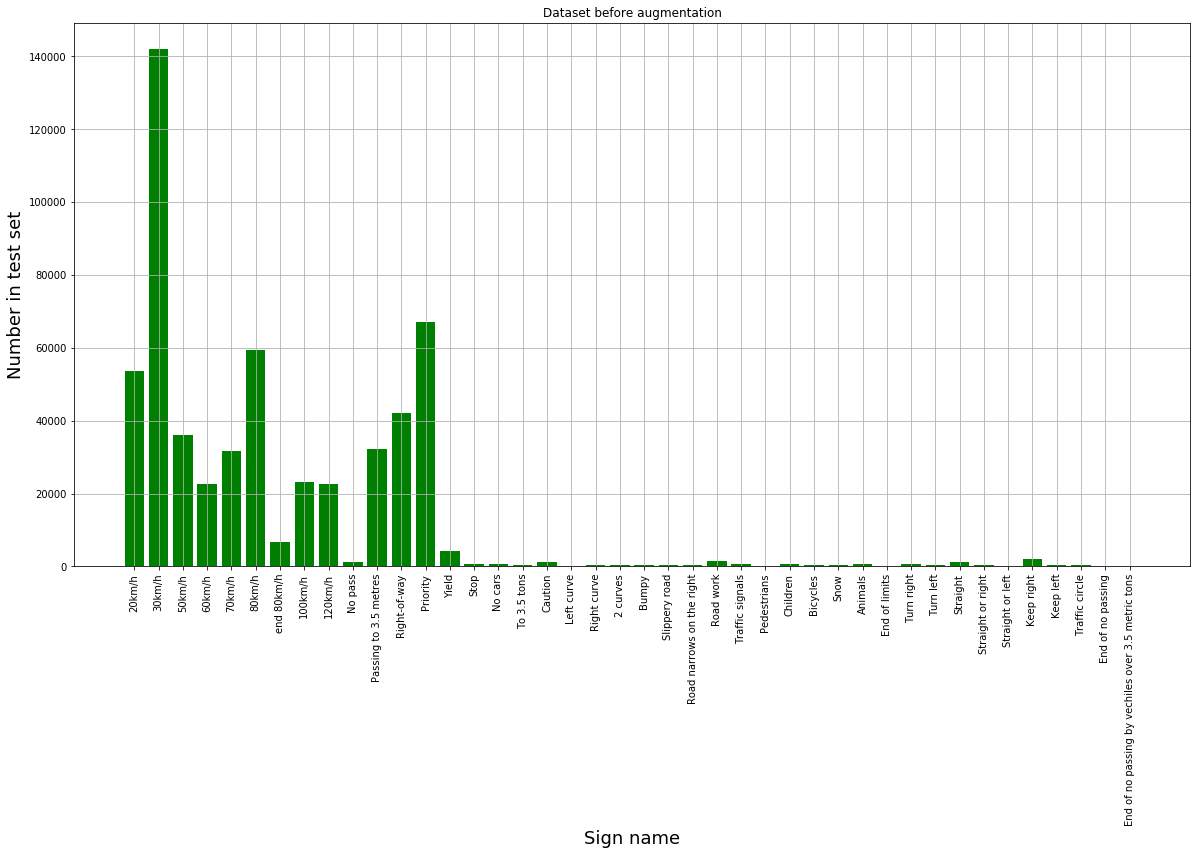

In [13]:
plot_bar(create_plot_date(images, sign_labels_dict), "Dataset before augmentation")

In [14]:
#print_signs(images)

In [15]:
transform_signs(images)

KeyboardInterrupt: 

In [ ]:
plot_bar(create_plot_date(images, sign_labels_dict), "Dataset after augmentation")

In [ ]:
print(images[path+'00018'][0])

In [103]:
Parameters = namedtuple('Parameters', [
        # Data parameters
        'num_classes', 'image_size', 
        # Training parameters
        'batch_size', 'max_epochs', 'log_epoch', 'print_epoch',
        # Optimisations
        'learning_rate_decay', 'learning_rate',
        'l2_reg_enabled', 'l2_lambda', 
        'early_stopping_enabled', 'early_stopping_patience', 
        'resume_training', 
        # Layers architecture
        'conv1_k', 'conv1_d', 'conv1_p', 
        'conv2_k', 'conv2_d', 'conv2_p', 
        'conv3_k', 'conv3_d', 'conv3_p', 
        'fc4_size', 'fc4_p'
    ])

In [105]:
import tensorflow as tf

def fully_connected(input, size):
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    return tf.nn.relu(fully_connected(input, size))

def conv_relu(input, kernel_size, depth):
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

def pool(input, size):
    return tf.nn.max_pool(
        input, 
        ksize = [1, size, size, 1], 
        strides = [1, size, size, 1], 
        padding = 'SAME'
    )